This notebook demonstrates how systematic analysis of tally scores is possible using Pandas dataframes. A dataframe can be automatically generated using the `Tally.get_pandas_dataframe(...)` method. Furthermore, by linking the tally data in a statepoint file with geometry and material information from a summary file, the dataframe can be shown with user-supplied labels.

**Note:** that this Notebook was created using the latest Pandas v0.16.1. Everything in the Notebook will wun with older versions of Pandas, but the multi-indexing option in >v0.15.0 makes the tables look prettier.

In [1]:
%matplotlib inline
import glob

from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd

import openmc

## Generate Input Files

First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
b10 = openmc.Nuclide('B10')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
zr90 = openmc.Nuclide('Zr90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pin.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our three materials, we can now create a materials file object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials collection
materials_file = openmc.Materials((fuel, water, zircaloy))

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='vacuum')
min_y = openmc.YPlane(y0=-10.71, boundary_type='vacuum')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10.71, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10.71, boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [7]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel - 0BA')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2
assembly.universes = [[pin_cell_universe] * 17] * 17

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [8]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [9]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

In [10]:
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 5 inactive batches and 15 minimum active batches each with 2500 particles. We also tell OpenMC to turn tally triggers on, which means it will keep running until some criterion on the uncertainty of tallies is reached.

In [11]:
# OpenMC simulation parameters
min_batches = 20
max_batches = 200
inactive = 5
particles = 2500

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = min_batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}
settings_file.trigger_active = True
settings_file.trigger_max_batches = max_batches

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a plot file that we can use to verify that our pin cell geometry was created successfully.

In [12]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [21.5, 21.5]
plot.pixels = [250, 250]
plot.color = 'mat'

# Instantiate a Plots collection and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [13]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

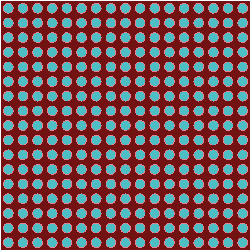

In [14]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice array of pin cells with fuel, cladding, and water! Before we run our simulation, we need to tell the code what we want to tally. The following code shows how to create a variety of tallies.

In [15]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()
tallies_file._tallies = []

Instantiate a fission rate mesh Tally

In [16]:
# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.width = [1.26, 1.26]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate energy Filter
energy_filter = openmc.EnergyFilter([0, 0.625, 20.0e6])

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter, energy_filter]
tally.scores = ['fission', 'nu-fission']

# Add mesh and Tally to Tallies
tallies_file.append(tally)

Instantiate a cell Tally with nuclides

In [17]:
# Instantiate tally Filter
cell_filter = openmc.CellFilter(fuel_cell.id)

# Instantiate the tally
tally = openmc.Tally(name='cell tally')
tally.filters = [cell_filter]
tally.scores = ['scatter-y2']
tally.nuclides = [u235, u238]

# Add mesh and tally to Tallies
tallies_file.append(tally)

Create a "distribcell" Tally. The distribcell filter allows us to tally multiple repeated instances of the same cell throughout the geometry.

In [18]:
# Instantiate tally Filter
distribcell_filter = openmc.DistribcellFilter(moderator_cell.id)

# Instantiate tally Trigger for kicks
trigger = openmc.Trigger(trigger_type='std_dev', threshold=5e-5)
trigger.scores = ['absorption']

# Instantiate the Tally
tally = openmc.Tally(name='distribcell tally')
tally.filters = [distribcell_filter]
tally.scores = ['absorption', 'scatter']
tally.triggers = [trigger]

# Add mesh and tally to Tallies
tallies_file.append(tally)

In [19]:
# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [20]:
# Remove old HDF5 (summary, statepoint) files
!rm statepoint.*

# Run OpenMC!
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

In [21]:
# We do not know how many batches were needed to satisfy the 
# tally trigger(s), so find the statepoint file(s)
statepoints = glob.glob('statepoint.*.h5')

# Load the last statepoint file
sp = openmc.StatePoint(statepoints[-1])

**Analyze the mesh fission rate tally**

In [22]:
# Find the mesh tally with the StatePoint API
tally = sp.get_tally(name='mesh tally')

# Print a little info about the mesh tally to the screen
print(tally)

Tally
	ID             =	10000
	Name           =	mesh tally
	Filters        =	
                		MeshFilter	[1]
                		EnergyFilter	[  0.00000000e+00   6.25000000e-01   2.00000000e+07]
	Nuclides       =	total 
	Scores         =	['fission', 'nu-fission']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [23]:
# Get the relative error for the thermal fission reaction 
# rates in the four corner pins 
data = tally.get_values(scores=['fission'],
                        filters=[openmc.MeshFilter, openmc.EnergyFilter], \
                        filter_bins=[((1,1),(1,17), (17,1), (17,17)), \
                                    ((0., 0.625),)], value='rel_err')
print(data)

[[[ 0.1501735 ]]

 [[ 0.21402727]]

 [[ 0.05936257]]

 [[ 0.13436703]]]


In [24]:
# Get a pandas dataframe for the mesh tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Set the Pandas float display settings
pd.options.display.float_format = '{:.2e}'.format

# Print the first twenty rows in the dataframe
df.head(20)

mesh 1       energy low [eV] energy high [eV]       score     mean  \
        x  y  z                                                         
0       1  1  1        0.00e+00         6.25e-01     fission 2.20e-04   
1       1  1  1        0.00e+00         6.25e-01  nu-fission 5.37e-04   
2       1  1  1        6.25e-01         2.00e+07     fission 7.43e-05   
3       1  1  1        6.25e-01         2.00e+07  nu-fission 1.97e-04   
4       1  2  1        0.00e+00         6.25e-01     fission 2.32e-04   
5       1  2  1        0.00e+00         6.25e-01  nu-fission 5.65e-04   
6       1  2  1        6.25e-01         2.00e+07     fission 6.96e-05   
7       1  2  1        6.25e-01         2.00e+07  nu-fission 1.86e-04   
8       1  3  1        0.00e+00         6.25e-01     fission 2.43e-04   
9       1  3  1        0.00e+00         6.25e-01  nu-fission 5.91e-04   
10      1  3  1        6.25e-01         2.00e+07     fission 7.27e-05   
11      1  3  1        6.25e-01         2.00e+07  nu-fission 1.93e-04   
12      1  4  1        0.00e+00         6.25e-01     fission 2.61e-04   
13      1  4  1        0.00e+00         6.25e-01  nu-fission 6.35e-04   
14      1  4  1        6.25e-01         2.00e+07     fission 6.00e-05   
15      1  4  1        6.25e-01         2.00e+07  nu-fission 1.59e-04   
16      1  5  1        0.00e+00         6.25e-01     fission 2.23e-04   
17      1  5  1        0.00e+00         6.25e-01  nu-fission 5.43e-04   
18      1  5  1        6.25e-01         2.00e+07     fission 7.93e-05   
19      1  5  1        6.25e-01         2.00e+07  nu-fission 2.07e-04   

   std. dev.  
              
0   3.31e-05  
1   8.06e-05  
2   7.91e-06  
3   1.96e-05  
4   4.97e-05  
5   1.21e-04  
6   6.90e-06  
7   1.90e-05  
8   3.24e-05  
9   7.90e-05  
10  4.76e-06  
11  1.14e-05  
12  4.48e-05  
13  1.09e-04  
14  4.53e-06  
15  1.17e-05  
16  2.89e-05  
17  7.04e-05  
18  7.77e-06  
19  1.94e-05

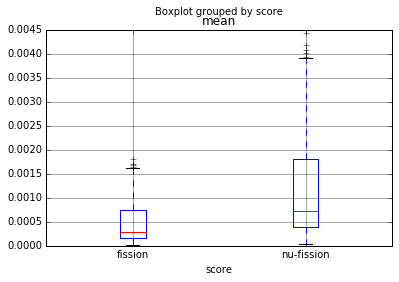

In [25]:
# Create a boxplot to view the distribution of
# fission and nu-fission rates in the pins
bp = df.boxplot(column='mean', by='score')

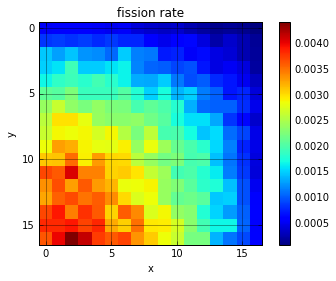

In [26]:
# Extract thermal nu-fission rates from pandas
fiss = df[df['score'] == 'nu-fission']
fiss = fiss[fiss['energy low [eV]'] == 0.0]

# Extract mean and reshape as 2D NumPy arrays
mean = fiss['mean'].reshape((17,17))

plt.imshow(mean, interpolation='nearest')
plt.title('fission rate')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

**Analyze the cell+nuclides scatter-y2 rate tally**

In [27]:
# Find the cell Tally with the StatePoint API
tally = sp.get_tally(name='cell tally')

# Print a little info about the cell tally to the screen
print(tally)

Tally
	ID             =	10001
	Name           =	cell tally
	Filters        =	
                		CellFilter	[10000]
	Nuclides       =	U235 U238 
	Scores         =	['scatter-Y0,0', 'scatter-Y1,-1', 'scatter-Y1,0', 'scatter-Y1,1', 'scatter-Y2,-2', 'scatter-Y2,-1', 'scatter-Y2,0', 'scatter-Y2,1', 'scatter-Y2,2']
	Estimator      =	analog



In [28]:
# Get a pandas dataframe for the cell tally data
df = tally.get_pandas_dataframe()

# Print the first twenty rows in the dataframe
df.head(100)

,cell,nuclide,score,mean,std. dev.
0,10000,U235,"scatter-Y0,0",3.84e-02,1.32e-03
1,10000,U235,"scatter-Y1,-1",3.61e-04,3.13e-04
2,10000,U235,"scatter-Y1,0",-2.38e-04,4.69e-04
3,10000,U235,"scatter-Y1,1",-5.08e-04,3.83e-04
4,10000,U235,"scatter-Y2,-2",6.68e-05,2.46e-04
5,10000,U235,"scatter-Y2,-1",6.47e-06,2.84e-04
6,10000,U235,"scatter-Y2,0",-1.41e-04,1.75e-04
7,10000,U235,"scatter-Y2,1",1.61e-04,2.33e-04
8,10000,U235,"scatter-Y2,2",-1.80e-05,1.97e-04
9,10000,U238,"scatter-Y0,0",2.33e+00,1.35e-02


Use the new Tally data retrieval API with pure NumPy

In [29]:
# Get the standard deviations for two of the spherical harmonic
# scattering reaction rates 
data = tally.get_values(scores=['scatter-Y2,2', 'scatter-Y0,0'], 
                        nuclides=['U238', 'U235'], value='std_dev')
print(data)

[[[ 0.00185463  0.01350521]
  [ 0.00019723  0.00131654]]]


**Analyze the distribcell tally**

In [30]:
# Find the distribcell Tally with the StatePoint API
tally = sp.get_tally(name='distribcell tally')

# Print a little info about the distribcell tally to the screen
print(tally)

Tally
	ID             =	10002
	Name           =	distribcell tally
	Filters        =	
                		DistribcellFilter	[10002]
	Nuclides       =	total 
	Scores         =	['absorption', 'scatter']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [31]:
# Get the relative error for the scattering reaction rates in
# the first 10 distribcell instances 
data = tally.get_values(scores=['scatter'], filters=[openmc.DistribcellFilter],
                        filter_bins=[(i,) for i in range(10)], value='rel_err')
print(data)

[[[ 0.05468423]]]


Print the distribcell tally dataframe

In [32]:
# Get a pandas dataframe for the distribcell tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Print the last twenty rows in the dataframe
df.tail(20)

level 1        level 2            level 3        distribcell       score  \
       univ   cell     lat               univ   cell                           
         id     id      id   x   y  z      id     id                           
558       0  10003   10001  16   7  0   10000  10002         279  absorption   
559       0  10003   10001  16   7  0   10000  10002         279     scatter   
560       0  10003   10001  16   8  0   10000  10002         280  absorption   
561       0  10003   10001  16   8  0   10000  10002         280     scatter   
562       0  10003   10001  16   9  0   10000  10002         281  absorption   
563       0  10003   10001  16   9  0   10000  10002         281     scatter   
564       0  10003   10001  16  10  0   10000  10002         282  absorption   
565       0  10003   10001  16  10  0   10000  10002         282     scatter   
566       0  10003   10001  16  11  0   10000  10002         283  absorption   
567       0  10003   10001  16  11  0   10000  10002         283     scatter   
568       0  10003   10001  16  12  0   10000  10002         284  absorption   
569       0  10003   10001  16  12  0   10000  10002         284     scatter   
570       0  10003   10001  16  13  0   10000  10002         285  absorption   
571       0  10003   10001  16  13  0   10000  10002         285     scatter   
572       0  10003   10001  16  14  0   10000  10002         286  absorption   
573       0  10003   10001  16  14  0   10000  10002         286     scatter   
574       0  10003   10001  16  15  0   10000  10002         287  absorption   
575       0  10003   10001  16  15  0   10000  10002         287     scatter   
576       0  10003   10001  16  16  0   10000  10002         288  absorption   
577       0  10003   10001  16  16  0   10000  10002         288     scatter   

        mean std. dev.  
                        
                        
558 8.72e-05  8.13e-06  
559 1.37e-02  6.98e-04  
560 1.03e-04  9.17e-06  
561 1.41e-02  6.26e-04  
562 9.41e-05  8.40e-06  
563 1.50e-02  6.92e-04  
564 9.56e-05  1.03e-05  
565 1.52e-02  5.37e-04  
566 1.06e-04  1.49e-05  
567 1.64e-02  8.14e-04  
568 1.16e-04  9.02e-06  
569 1.64e-02  6.00e-04  
570 1.25e-04  1.12e-05  
571 1.87e-02  8.26e-04  
572 1.47e-04  1.49e-05  
573 1.94e-02  7.71e-04  
574 1.31e-04  9.84e-06  
575 1.97e-02  7.93e-04  
576 1.23e-04  1.07e-05  
577 1.97e-02  7.34e-04

In [33]:
# Show summary statistics for absorption distribcell tally data
absorption = df[df['score'] == 'absorption']
absorption[['mean', 'std. dev.']].dropna().describe()

# Note that the maximum standard deviation does indeed
# meet the 5e-4 threshold set by the tally trigger

,mean,std. dev.
,,
,,
count,2.89e+02,2.89e+02
mean,4.16e-04,2.42e-05
std,2.39e-04,1.03e-05
min,1.90e-05,3.80e-06
25%,1.99e-04,1.61e-05
50%,4.09e-04,2.37e-05
75%,6.00e-04,3.08e-05
max,9.07e-04,5.38e-05


Perform a statistical test comparing the tally sample distributions for two categories of fuel pins.

In [34]:
# Extract tally data from pins in the pins divided along y=x diagonal 
multi_index = ('level 2', 'lat',)
lower = df[df[multi_index + ('x',)] + df[multi_index + ('y',)] < 16]
upper = df[df[multi_index + ('x',)] + df[multi_index + ('y',)] > 16]
lower = lower[lower['score'] == 'absorption']
upper = upper[upper['score'] == 'absorption']

# Perform non-parametric Mann-Whitney U Test to see if the 
# absorption rates (may) come from same sampling distribution
u, p = scipy.stats.mannwhitneyu(lower['mean'], upper['mean'])
print('Mann-Whitney Test p-value: {0}'.format(p))

Mann-Whitney Test p-value: 0.7234916721800682


Note that the symmetry implied by the y=x diagonal ensures that the two sampling distributions are identical. Indeed, as illustrated by the test above, for any reasonable significance level (*e.g.*, $\alpha$=0.05) one would **not reject** the null hypothesis that the two sampling distributions are identical.

Next, perform the same test but with two groupings of pins which are not symmetrically identical to one another.

In [35]:
# Extract tally data from pins in the pins divided along y=-x diagonal
multi_index = ('level 2', 'lat',)
lower = df[df[multi_index + ('x',)] > df[multi_index + ('y',)]]
upper = df[df[multi_index + ('x',)] < df[multi_index + ('y',)]]
lower = lower[lower['score'] == 'absorption']
upper = upper[upper['score'] == 'absorption']

# Perform non-parametric Mann-Whitney U Test to see if the 
# absorption rates (may) come from same sampling distribution
u, p = scipy.stats.mannwhitneyu(lower['mean'], upper['mean'])
print('Mann-Whitney Test p-value: {0}'.format(p))

Mann-Whitney Test p-value: 3.5054120724573393e-41


Note that the asymmetry implied by the y=-x diagonal ensures that the two sampling distributions are *not* identical. Indeed, as illustrated by the test above, for any reasonable significance level (*e.g.*, $\alpha$=0.05) one would **reject** the null hypothesis that the two sampling distributions are identical.

/home/romano/miniconda3/envs/default/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


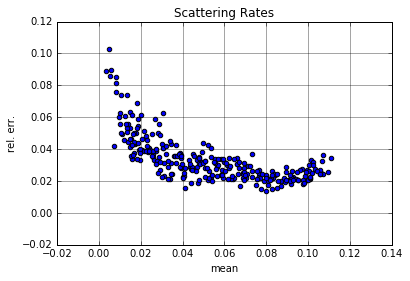

In [36]:
# Extract the scatter tally data from pandas
scatter = df[df['score'] == 'scatter']

scatter['rel. err.'] = scatter['std. dev.'] / scatter['mean']

# Show a scatter plot of the mean vs. the std. dev.
scatter.plot(kind='scatter', x='mean', y='rel. err.', title='Scattering Rates')

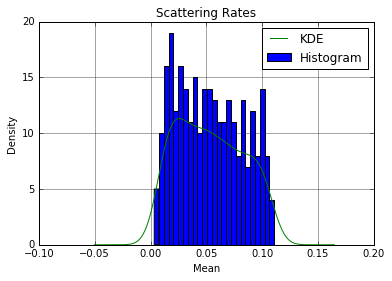

In [37]:
# Plot a histogram and kernel density estimate for the scattering rates
scatter['mean'].plot(kind='hist', bins=25)
scatter['mean'].plot(kind='kde')
plt.title('Scattering Rates')
plt.xlabel('Mean')
plt.legend(['KDE', 'Histogram'])